<center>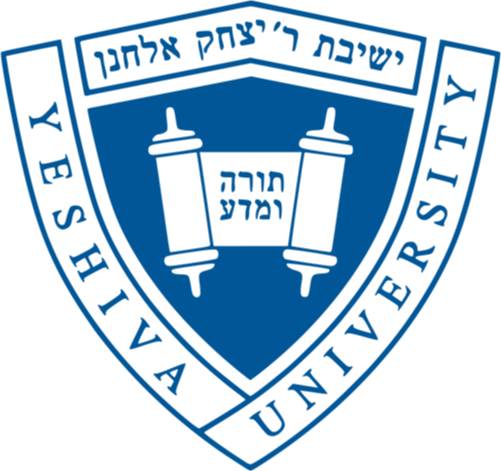</center>

<h1 style='text-align: center;'>Katz School of Science and Health</h1>
<h1 style='text-align: center;'>AIM 5000 Artificial Intelligence</h1>
<p>
<h2 style='text-align: center;'>Final Project</h1>
<br><br>
<h2 style='text-align: center;'>From Cells to Answers: The New Frontier of Visual Question Answering in Pathology</h1>
<br><br>

<div style="display: flex; justify-content: center;">
    <table style="border-collapse: collapse; border: 0;">
        <tr>
            <td style="text-align:center; vertical-align:middle; padding:10px 40px 10px 10px; border: 0;">
                <h3 style="margin: 0;">Sheng-Han Yueh</h3>
            </td>
            <td style="text-align:center; vertical-align:middle; padding:10px 10px 10px 40px; border: 0;">
                <h3 style="margin: 0;">Radek Jan Holik</h3>
            </td>
            <td style="text-align:center; vertical-align:middle; padding:10px 10px 10px 40px; border: 0;">
                <h3 style="margin: 0;">Jiuge Ren</h3>
            </td>
            <td style="text-align:center; vertical-align:middle; padding:10px 10px 10px 40px; border: 0;">
                <h3 style="margin: 0;">Sayed Raheel Hussain</h3>
            </td>
        </tr>
    </table>
</div>
<br>
<br>
<br>

# __Package Import__

In [1]:
# General system and utility libraries
import platform
# from datetime import datetime, timedelta
# from timeit import default_timer as timer
import psutil
import win32com.client


# Data manipulation and analysis libraries
import pandas as pd
import numpy as np
import pickle
# from collections import Counter
# from sklearn.model_selection import train_test_split

# # Image processing libraries
# from PIL import Image

# # Network and web-related libraries
# import requests

# Machine learning and deep learning libraries
import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
# from torch.nn.utils.rnn import pad_sequence
# import torch.nn.functional as F
import torchvision
# from torchvision import transforms

# # Natural language processing libraries
# import transformers
# from transformers import Blip2Processor, Blip2ForConditionalGeneration, get_cosine_schedule_with_warmup
# from transformers import AutoTokenizer, AutoFeatureExtractor

# Data visualization libraries
import matplotlib.pyplot as plt

# # Metrics and evaluation libraries
# from sklearn.metrics import f1_score

# # Jupyter notebook specific libraries
# from IPython.display import clear_output

# Disable warnings for clean notebook presentation
import warnings
warnings.filterwarnings("ignore")

# Configuration for libraries
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_colwidth', None)


In [2]:
def get_basic_system_info():
    # Get CPU Name using WMI
    wmi = win32com.client.GetObject("winmgmts:")
    for item in wmi.ExecQuery("select * from Win32_Processor"):
        cpu_name = item.Name

    # Total RAM capacity in bytes
    total_ram_bytes = psutil.virtual_memory().total

    # Convert total RAM from bytes to GB for better readability
    total_ram_gb = total_ram_bytes / (1024 ** 3)

    return cpu_name, total_ram_gb

print(f"Python Version : {platform.python_version()}")
print(f"Torchvision : {torchvision.__version__}")
print(f"PyTorch Version : {torch.__version__}")
print(f"CUDA Version : {torch.version.cuda}")

print()

os_info = platform.uname()
print(f"OS System: {os_info.system} {os_info.release}")

print()

cpu_name, total_ram_gb = get_basic_system_info()
print(f"CPU Name: {cpu_name}")
print(f"Total RAM Capacity: {total_ram_gb:.2f} GB")

print()

if torch.cuda.is_available():
  print("CUDA available. Using GPU acceleration.")
  print(f"Number of CUDA devices : {torch.cuda.device_count()}")
  print(f"Device name : {torch.cuda.get_device_name(0)}")
  device = "cuda:0"
else:
  print("CUDA is NOT available. Using CPU for training.")
  device = "cpu"

Python Version : 3.9.12
Torchvision : 0.14.1
PyTorch Version : 1.13.1
CUDA Version : 11.7

OS System: Windows 10

CPU Name: 12th Gen Intel(R) Core(TM) i9-12900HK
Total RAM Capacity: 31.68 GB

CUDA available. Using GPU acceleration.
Number of CUDA devices : 1
Device name : NVIDIA GeForce RTX 3050 Ti Laptop GPU


# __Data Preprocessing__

### Loading Data

In [3]:
# Data Paths
data_dir = "./data/"

vqa_path = data_dir + "metadata.csv"

In [4]:
df_vqa = pd.read_csv(vqa_path)

print(df_vqa.columns)

Index(['Image', 'Question', 'Answer', 'File_Name'], dtype='object')


In [5]:
# Missing values in each column
print("Missing values in df_vqa columns:")
print(df_vqa.isnull().sum())

Missing values in df_vqa columns:
Image        0
Question     0
Answer       0
File_Name    0
dtype: int64


In [6]:
df_vqa

,Image,Question,Answer,File_Name
0,422,Where are liver stem cells (oval cells) located?,in the canals of hering,./Data/Images/img_0001.jpg
1,422,What are stained here with an immunohistochemi...,bile duct cells and canals of hering,./Data/Images/img_0001.jpg
2,422,What are bile duct cells and canals of Hering ...,an immunohistochemical stain,./Data/Images/img_0001.jpg
3,422,Are bile duct cells and canals of Hering stain...,yes,./Data/Images/img_0001.jpg
4,986,What shows dissolution of the tissue?,an infarct in the brain,./Data/Images/img_0002.jpg
...,...,...,...,...
32627,648,What is present?,kidney,./Data/Images/img_4289.jpg
32628,648,Is kidney present?,yes,./Data/Images/img_4289.jpg
32629,648,What is present?,sarcoidosis,./Data/Images/img_4289.jpg
32630,648,Is sarcoidosis present?,yes,./Data/Images/img_4289.jpg


### Distribution Based on the Length of the Answers and Questions

#### Questions

In [7]:
# mean_value_q = df_vqa['Question'].str.len().mean()

# # Plot the histogram
# hist, bin_edges, _ = plt.hist(df_vqa['Question'].str.len(), bins = 128, edgecolor = 'k')

# plt.xlabel('\nString Length', fontsize = 14)
# plt.ylabel('Frequency', fontsize = 14)
# plt.title('Question string length distribution', fontsize = 16)

# # Add a vertical line to indicate the mean value
# plt.plot([mean_value_q, mean_value_q], [0, int(max(hist)/20)], color='red', linestyle ='solid', linewidth = 3)
# plt.text(mean_value_q - 20, - 1000,'μ: {:.2f}'.format(mean_value_q), rotation = 0, color = 'red', fontsize = 11)

# plt.show()

#### Answers

In [8]:
# mean_value_a = df_vqa['Answer'].str.len().mean()

# # Plot the distribution using a histogram
# hist, bin_edges, _ = plt.hist(df_vqa['Answer'].str.len(), bins = 128, edgecolor = 'k')

# plt.xlabel('\nString Length', fontsize = 14)
# plt.ylabel('Frequency', fontsize = 14)
# plt.title('Answer string length distribution', fontsize = 16)

# # Add a vertical line to indicate the mean value
# plt.plot([mean_value_a, mean_value_a], [0, int(max(hist)/20)], color='red', linestyle ='solid', linewidth = 3)
# plt.text(mean_value_a - 15, - 1200,'μ: {:.2f}'.format(mean_value_a), rotation = 0, color = 'red', fontsize = 11)

# plt.show()

# __Vision-Language Model Building__

In [9]:
# # Load pre-trained weights
# weights_path = './Models/Llama2/llama-2-7b-chat/consolidated.00.pth'
# llama2 = LLaMAForQuestionAnswering.from_pretrained(weights_path)

# # Load tokenizer
# tokenizer_path = './Model/Llama2/tokenizer.model' 
# tokenizer = LLaMAForQuestionAnswering.from_pretrained(tokenizer_path)

## Pix2Struct

Kenton Lee and Mandar Joshi and Iulia Turc and Hexiang Hu and Fangyu Liu and Julian Eisenschlos and Urvashi Khandelwal and Peter Shaw and Ming-Wei Chang and Kristina Toutanova (2023)Pix2Struct: Screenshot Parsing as Pretraining for Visual Language Understanding

Pix2Struct is pretrained by learning to parse masked screenshots of web pages into simplified HTML.

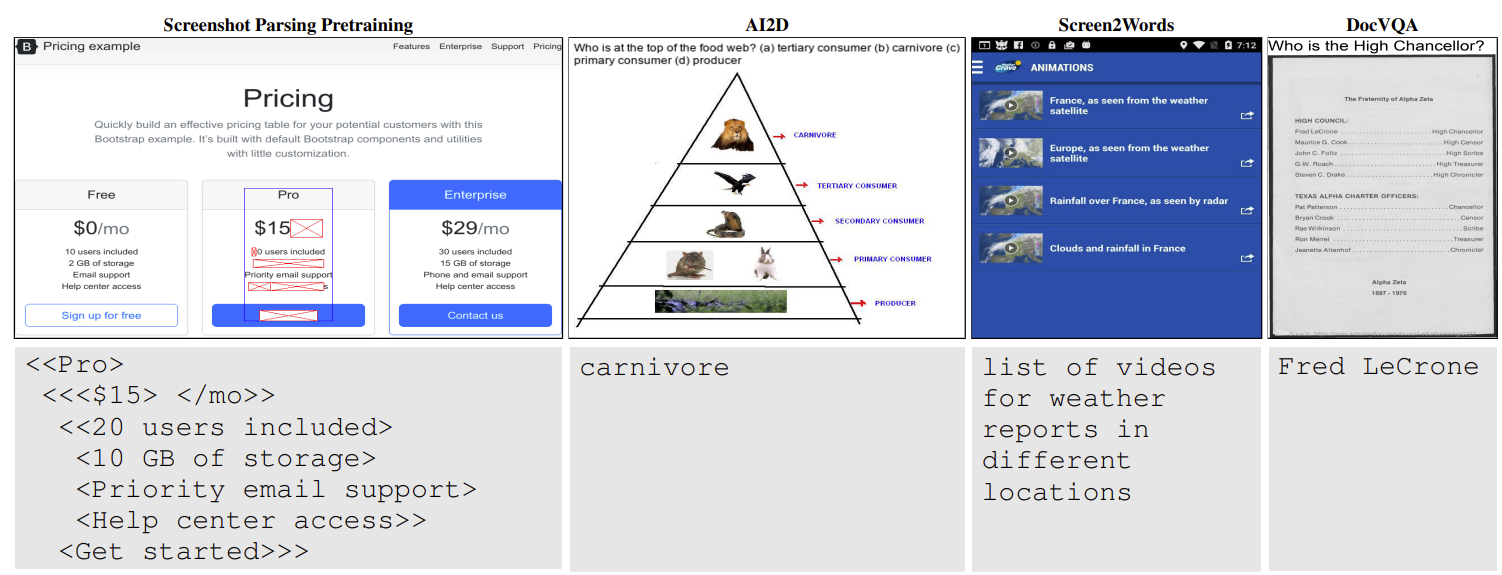

- Architecture: Pix2Struct is based on the ViT (Vision Transformer) architecture, with modifications for improved robustness.
- Pretraining: It uses self-supervised pairs of input images and target text from web pages, with a focus on screenshot parsing.
- Warming Up: Before pretraining, a warm-up stage involves simple reading tasks for better stability and learning.
- Fine-tuning: During fine-tuning, the method preprocesses data to match specific tasks, such as image captioning, visual question answering, multiple choice answers, or referring expressions.
- Versatility: Pix2Struct provides a flexible framework for visual language understanding, bridging image processing and text generation for various applications.

https://github.com/google-research/pix2struct

###  https://github.com/google-research/pix2struct

Data Fields
- 'image': the image referenced by the question-answer pair.
- 'question': the question about the image.
- 'answer': the expected answer.

In [10]:
# from transformers import Pix2StructConfig, Pix2StructForConditionalGeneration,Pix2StructTextConfig,Pix2StructVisionConfig

# # Initializing a Pix2StructConfig with google/pix2struct-base style configuration
# configuration = Pix2StructConfig()

# # Initializing a Pix2StructForConditionalGeneration (with random weights) from the google/pix2struct-base style configuration
# model = Pix2StructForConditionalGeneration(configuration)

# # Accessing the model configuration
# configuration = model.config

# # We can also initialize a Pix2StructConfig from a Pix2StructTextConfig and a Pix2StructVisionConfig

# # Initializing a Pix2Struct text and Pix2Struct vision configuration
# config_text = Pix2StructTextConfig()
# config_vision = Pix2StructVisionConfig()

# config = Pix2StructConfig.from_text_vision_configs(config_text, config_vision)

In [11]:
# from transformers import AutoProcessor, Pix2StructTextModel

# processor = AutoProcessor.from_pretrained("google/pix2struct-textcaps-base")
# model = Pix2StructTextModel.from_pretrained("google/pix2struct-textcaps-base")

# inputs = processor(text="Hello, my dog is cute", return_tensors="pt")
# outputs = model(**inputs)
# loss = outputs.loss

In [12]:
# import requests
# from PIL import Image
# from transformers import AutoProcessor, Pix2StructVisionModel

# image_processor = AutoProcessor.from_pretrained("google/pix2struct-textcaps-base")
# model = Pix2StructVisionModel.from_pretrained("google/pix2struct-textcaps-base")

# url = "https://www.ilankelman.org/stopsigns/australia.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

# inputs = image_processor(images=image, return_tensors="pt")
# with torch.no_grad():
#     outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state
# list(last_hidden_states.shape)

In [13]:
df_vqa

,Image,Question,Answer,File_Name
0,422,Where are liver stem cells (oval cells) located?,in the canals of hering,./Data/Images/img_0001.jpg
1,422,What are stained here with an immunohistochemi...,bile duct cells and canals of hering,./Data/Images/img_0001.jpg
2,422,What are bile duct cells and canals of Hering ...,an immunohistochemical stain,./Data/Images/img_0001.jpg
3,422,Are bile duct cells and canals of Hering stain...,yes,./Data/Images/img_0001.jpg
4,986,What shows dissolution of the tissue?,an infarct in the brain,./Data/Images/img_0002.jpg
...,...,...,...,...
32627,648,What is present?,kidney,./Data/Images/img_4289.jpg
32628,648,Is kidney present?,yes,./Data/Images/img_4289.jpg
32629,648,What is present?,sarcoidosis,./Data/Images/img_4289.jpg
32630,648,Is sarcoidosis present?,yes,./Data/Images/img_4289.jpg


### test with the picture-generated text

In [14]:
file_paths = df_vqa['File_Name']
file_q = df_vqa['Question']

In [15]:
len(file_q)

32632

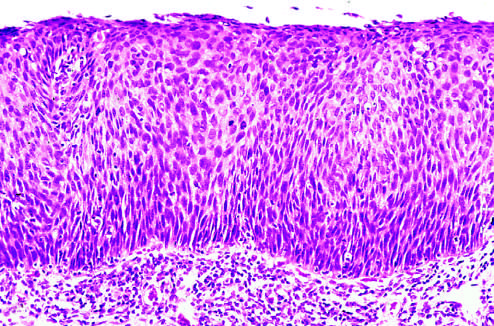

Question: Is there no tumor in the subepithelial stroma?
Answer: No


In [16]:
from transformers import Pix2StructForConditionalGeneration as psg
from transformers import Pix2StructProcessor as psp
from PIL import Image
model = psg.from_pretrained("google/pix2struct-docvqa-large")
processor = psp.from_pretrained("google/pix2struct-docvqa-large")
i = 200
image = Image.open(file_paths[i])
display(image.convert("RGBA"))
question = file_q[i]
print("Question:", question)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
inputs = processor(images=[image], text=[question], return_tensors="pt")#.to(DEVICE)
# model = model.to(DEVICE)
predictions = model.generate(**inputs)
answer = processor.decode(predictions[0], skip_special_tokens=True)
print("Answer:",answer)

In [17]:
from transformers import Pix2StructForConditionalGeneration as psg
from transformers import Pix2StructProcessor as psp
from PIL import Image
from tqdm import trange

model = psg.from_pretrained("google/pix2struct-docvqa-large")
processor = psp.from_pretrained("google/pix2struct-docvqa-large")
pre_a=[]
for i in trange(96,len(file_q)):
    image = Image.open(file_paths[i])
#     display(image.convert("RGBA"))
    question = file_q[i]
#     print("Question:", question)
#     DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    inputs = processor(images=[image], text=[question], return_tensors="pt")#.to(DEVICE)
    # model = model.to(DEVICE)
    predictions = model.generate(**inputs)
    answer = processor.decode(predictions[0], skip_special_tokens=True)
    pre_a.append(answer)
#     print(pre_a)
#     print("Answer:",answer)
df_vqa['Pix2Struct']=pre_a

  4%|▍         | 1249/32536 [14:16:34<357:37:02, 41.15s/it]  


KeyboardInterrupt: 

In [18]:
pre_a

['Atrophy of the brain',
 'Stained',
 'Is a thrombosed artery stained for elastic tissue?',
 '5',
 'Embolus',
 'edema',
 'CENTIMETERS',
 'CENTIMETERS',
 'CENTIMETERS',
 'CENTIMETERS',
 'white chalky deposits',
 'Eosinophils',
 'late-phase reaction',
 'immediate reaction',
 'Tuberculous granuloma',
 'Antibodies',
 'Speckled Pattern',
 'Antibodies',
 'Failure to stain seen with antibodies against various nuclear antigens, including Sm and RNPs',
 'Is immunoperoxidase staining seen with antibodies against various nuclear antigens, including Sm and',
 'wall of the artery',
 'Antibodies',
 'systemic sclerosis',
 'systemic sclerosis, Sjogren syndrome, and other diseases',
 'principal cellular alterations',
 'neutrophils',
 'Dark green polypeptides',
 'genes that encode several proteins involved in antigen processing seen in some cases of systemic sclerosis,',
 'wire loops',
 'Subendothelial dense deposits correspond to?',
 'Light microscopy',
 'Do thrombus in the left and right ventricular a

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, Pix2StructForConditionalGeneration

processor = AutoProcessor.from_pretrained("google/pix2struct-base")
model = Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-base")

url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "A stop sign is on the street corner."

inputs = processor(images=image, return_tensors="pt")
labels = processor(text=text, return_tensors="pt").input_ids

# forward pass
outputs = model(**inputs, labels=labels)
loss = outputs.loss
print(f"{loss.item():.5f}")

## Fine-tune a pretrained model

In [ ]:
import datasets
dataset = datasets.load_dataset("imagefolder", data_dir="./data/")

## __BLIP-2 Model__ (Pre-trained)
## (Bidirectional Link between Image and text model, version 2)

<p>
  Li, J., Li, D., Savarese, S., & Hoi, S. (2023). 
  <i>BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models</i>. 
  <a href="https://arxiv.org/abs/2301.12597">arXiv preprint arXiv:2301.12597</a>.
</p>

https://huggingface.co/Salesforce/blip2-opt-2.7b

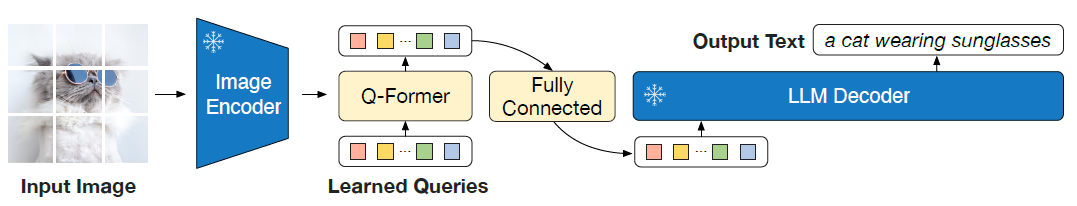

<p>
    The BLIP2 model contains the following key modules:
</p> 
<ul> 
    <li>
        <b>Vision Encoder</b> - A convolutional vision transformer like ViT or DeiT that encodes images into visual features.
    </li>
    <li>
        <b>Text Encoder</b> - A transformer encoder like BERT that encodes text into textual features.
    </li>
    <li>
        <b>Q-Former</b> - A transformer encoder that specifically encodes questions.
    </li> 
    <li>
        <b>Cross-Modal Projection</b> - Learns joint embeddings of visual and textual features.
    </li>
    <li>
        <b>Text Decoder</b> - An autoregressive transformer decoder like GPT/T5 that generates text conditioned on the encoded representations
    </li> 
</ul> 
<p>
    These components allow encoding multimodal context (images, text, questions) and decoding natural language responses.
</p>

### Model Definition

In [ ]:
# # Pre-trained models

# processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
# # processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
# # processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xxl")



# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype = torch.float16, device_map = "auto")
# # model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl", torch_dtype = torch.float16, device_map = "auto")
# # model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xxl", torch_dtype = torch.float16, device_map = "auto")

In [ ]:
# # Freeze all layers of vision model
# for param in model.vision_model.parameters():
#   param.requires_grad = False

# # Unfreeze last layer
# params = list(model.vision_model.parameters()) 
# params[-1].requires_grad = True

# # Freeze language model   
# for param in model.language_model.parameters():
#   param.requires_grad = False

In [ ]:
# # Model Parameters
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} model trainable parameters")

# print(f"\nIs my model in GPU? : {next(model.parameters()).is_cuda}\n")

# # GPU memory cache size
# if torch.cuda.is_available():
#     print(f"The allocated memory in the GPU for the model : {torch.cuda.memory_allocated()/(1024 * 1024):.3f}MB")

### Model Testing

In [ ]:
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"

# image = Image.open(requests.get(url, stream=True).raw)
# image 

In [ ]:
# # question = "Question: " + "What is next to these cats?"
# # question = "Question: " + "What are these two cats lying on?"
# # question = "Question: " + "How many cats are there?"
# question = "Question: " + "What color are these two cats?"
# # question = "Question: " + "How many dogs are there?"


# transcript = "There are two cats lying on a red blanket. Next to them are two remote controls."

In [ ]:
# full_prompt = transcript + " " + question + " Answer:"

# inputs = processor(images = image, text = full_prompt, return_tensors = "pt").to(device, torch.float16)

# generated_ids = model.generate(**inputs)

# generated_text = processor.batch_decode(generated_ids, skip_special_tokens = True)[0].strip()

# print(generated_text)

# __Data Preprocessing__

### Loading Data

In [ ]:
# # Data Paths
# data_dir = "./data/"

# qa_path = data_dir + "qa.json"
# transcript_path = data_dir + "transcript.json"
# img_path = data_dir + "images.json"

In [ ]:
# df_qa = pd.read_json(qa_path)
# df_transcript = pd.read_json(transcript_path) 
# df_image = pd.read_json(img_path)

# print(df_qa.columns)
# print(df_transcript.columns)
# print(df_image.columns)

In [ ]:
# # Missing values in each column
# print("Missing values in df_qa columns:")
# print(df_qa.isnull().sum())

# print("\nMissing values in df_transcript columns:")
# print(df_transcript.isnull().sum())

# print("\nMissing values in df_image columns:")
# print(df_image.isnull().sum())

#### QAs

In [ ]:
# df_qa_counts = df_qa['week'].value_counts().reset_index().sort_values(by = 'week')
# df_qa_total_count = df_qa_counts['count'].sum()
# df_qa_total_row = pd.DataFrame({'week': ['Total'], 'count': [df_qa_total_count]})
# df_qa_counts = pd.concat([df_qa_counts, df_qa_total_row], ignore_index=True)
# print(df_qa_counts)

#### Transcipt

In [ ]:
# df_transcript_counts = df_transcript['week'].value_counts().reset_index().sort_values(by = 'week')
# df_transcript_total_count = df_transcript_counts['count'].sum()
# df_transcript_total_row = pd.DataFrame({'week': ['Total'], 'count': [df_transcript_total_count]})
# df_transcript_counts = pd.concat([df_transcript_counts, df_transcript_total_row], ignore_index=True)
# print(df_transcript_counts)

#### Images

In [ ]:
# # Renaming images

# import os

# # Define the directory path where the images are located
# directory = './data/imgs/'

# # Loop through the directories (e.g., week_01, week_02, etc.)
# for week_folder in os.listdir(directory):
#     week_number = week_folder.split('_')[-1]  # Extract the week number
#     week_path = os.path.join(directory, week_folder)
    
#     # Check if it's a directory
#     if os.path.isdir(week_path):
#         page_number = 1
        
#         # Loop through the images in the week directory
#         for image_name in sorted(os.listdir(week_path)):
#             # Construct the old and new image paths
#             old_image_path = os.path.join(week_path, image_name)
#             new_image_name = f'week_{week_number}_page_{page_number:03}.png'
#             new_image_path = os.path.join(week_path, new_image_name)

#             # Rename the image
#             os.rename(old_image_path, new_image_path)

#             # Increment the page number
#             page_number += 1



In [ ]:
# df_images_counts = df_image['week'].value_counts().reset_index().sort_values(by = 'week')
# df_images_total_count = df_images_counts['count'].sum()
# df_images_total_row = pd.DataFrame({'week': ['Total'], 'count': [df_images_total_count]})
# df_images_counts = pd.concat([df_images_counts, df_images_total_row], ignore_index=True)
# print(df_images_counts)

### Creating a Dataset

In [ ]:
# # Merge the dataframes based on 'week' and 'page'
# df_merged = df_qa.merge(df_transcript, on = ['week', 'page']).merge(df_image, on = ['week', 'page'])

# # Select and rename the desired columns
# df_final = df_merged[['instruction', 'response', 'transcript', 'name', 'path']]
# df_final = df_final.rename(columns = {
#     'instruction': 'question',
#     'response': 'answer'
# })

# df_final.head()

### Test the Model on a Sample from the Dataset Before Training

In [ ]:
# MAX_TOKENS = 512 - 3  # 1 for [CLS], 1 for [SEP], 1 for safety

# results = []

# # Select 20 records from df_final
# df_samples = df_final[1000:1020]

# # Iterate over the df_samples dataframe
# for idx, (index, row) in enumerate(df_samples.iterrows(), start=1):
#     print(f"\rProcessing record: {idx}/{len(df_samples)}", end="")
    

#     # Load image
#     image_path = row['path']
#     image = Image.open(image_path)
    
#     # Construct the prompt
#     question = "Question: " + row['question']
#     transcript = row['transcript']
#     full_prompt = transcript + " " + question + " Answer:"

#     # Truncate the text to fit within the model's token limit
#     inputs = processor(text = full_prompt, return_tensors = "pt", truncation = True, max_length = MAX_TOKENS)
#     truncated_text = processor.decode(inputs['input_ids'][0])
    
    
#     # Process inputs
#     inputs = processor(images = image, text = truncated_text, return_tensors = "pt").to(device, torch.float16)

#     # Generate answer
#     generated_ids = model.generate(**inputs)
#     generated_text = processor.batch_decode(generated_ids, skip_special_tokens = True)[0].strip()

#     # Append results
#     results.append({
#         'question': row['question'],
#         'transcript': row['transcript'],
#         'true_answer': row['answer'],
#         'generated_answer': generated_text
#     })

# # Print a new line to clear the progress line
# print()

# # Convert results to dataframe
# df_results_before_training = pd.DataFrame(results)

In [ ]:
# df_results_before_training

## Training and Validation Data

In [ ]:
# # Splitting df_results into 80% training and 20% validation
# df_train, df_val = train_test_split(df_final, test_size = 0.2, random_state = 2023)

# print("Training set size:", len(df_train))
# print("Validation set size:", len(df_val))

### Convert DataFrame to Dataset

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, processor):
#         self.dataframe = dataframe
#         self.processor = processor

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):

#         # Load image
#         sample = self.dataframe.iloc[idx]
#         image_path = sample['path']
#         image = Image.open(image_path)

#         # Construct the prompt
#         question = "Question: " + sample['question']
#         transcript = sample['transcript']
#         full_prompt = transcript + " " + question + " Answer:"

#         # Truncate the text to fit within the model's token limit
#         inputs = self.processor(text = full_prompt, return_tensors = "pt", truncation = True, max_length = MAX_TOKENS)
#         truncated_text = self.processor.decode(inputs['input_ids'][0])

#         # Process inputs
#         inputs = self.processor(images = image, text = truncated_text, return_tensors = "pt")
        
#         # Tokenize the true answer
#         true_answer = sample['answer']
#         true_answer_ids = self.processor(text = true_answer, return_tensors = "pt")['input_ids'][0]
        
#         return inputs, true_answer_ids

In [ ]:
# train_dataset = CustomDataset(df_train, processor)
# val_dataset = CustomDataset(df_val, processor)

In [ ]:
# print("Number of samples in train_dataset:", len(train_dataset))
# print("Number of samples in val_dataset:", len(val_dataset))

### Convert Dataset to DataLoader

In [ ]:
# def custom_collate(batch):
#     # Separating the inputs and labels from the batch
#     input_tuples, true_answer_ids = zip(*batch)

#     # Convert the input_tuples to a dictionary for easier manipulation
#     inputs = {}
#     for key in input_tuples[0]:
#         inputs[key] = [sample[key] for sample in input_tuples]

#     # Determine the maximum sequence length for padding
#     max_length = max([x.size(1) for x in inputs['input_ids']])
    
#     # Padding the inputs
#     for key, value in inputs.items():
#         if isinstance(value[0], torch.Tensor):
#             if len(value[0].shape) == 2:  # For 2D tensors like input_ids
#                 # Ensure all sequences are of the same length by padding/truncating
#                 value = [torch.cat([v, torch.zeros((1, max_length - v.size(1)), dtype = v.dtype, device=v.device)], dim = 1) if v.size(1) < max_length else v[:, :max_length] for v in value]
#                 inputs[key] = torch.cat(value, dim = 0)
#             elif len(value[0].shape) == 4:  # For 4D tensors like images
#                 # Stack the images directly
#                 inputs[key] = torch.cat(value, dim = 0)

#     true_answer_ids = pad_sequence(true_answer_ids, batch_first = True)

#     return inputs, true_answer_ids

In [ ]:
# batch_size = 1

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = custom_collate)
# val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, collate_fn = custom_collate)

In [ ]:
# print("Number of batches in train_loader:", len(train_loader))
# print("Number of batches in val_loader:", len(val_loader))

# print(f"\nlen(train_loader.dataset) = {len(train_loader.dataset)}")
# print(f"train_loader.batch_size = {train_loader.batch_size}")

# print(f"\nlen(val_loader.dataset) = {len(val_loader.dataset)}")
# print(f"val_loader.batch_size = {val_loader.batch_size}")

#### Three Batch Size

In [ ]:
# for idx, (batch_inputs, batch_true_answer_ids) in enumerate(train_loader):

#     if idx >= 3:  # Stop after 3 batches
#         break
    
#     print(f"Batch {idx + 1} sizes:")
#     for key, item in batch_inputs.items():
#         if isinstance(item, torch.Tensor):
#             print(f"{key}.shape = {item.shape}")
#         else:
#             print(f"{key} is not a tensor.")
#     print(f"true_answer_ids.shape = {batch_true_answer_ids.shape}\n")

# __Training__

#### Auxiliary Functions

In [ ]:
# # Plot and print during training

# def update_plots(loss_values_train, loss_values_val, acc_values_train, acc_values_val, print_messages):
#     clear_output(wait = True)

#     # Display print messages
#     for message in print_messages:
#         print(message)

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 5))

#     # Plot loss values
#     ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = "Train Loss")
#     ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = "Validation Loss")
#     ax1.set_xlabel("Epoch")
#     ax1.set_ylabel("Loss")
#     ax1.legend()
#     ax1.set_title("Loss Values")
#     ax1.grid(linestyle = "--", linewidth = 0.75)

#     # Plot IoU values
#     ax2.plot(range(1, len(acc_values_train) + 1), acc_values_train, label = "Train Accuracy (F1 Score)")
#     ax2.plot(range(1, len(acc_values_val) + 1), acc_values_val, label = "Validation Accuracy (F1 Score)")
#     ax2.set_xlabel("Epoch")
#     ax2.set_ylabel("Accuracy (%)")
#     ax2.legend()
#     ax2.set_title("Accuracy Values (F1 Score)")
#     ax2.grid(linestyle = "--", linewidth = 0.75)

#     plt.show()

# def time_to_seconds(time_string):
#     '''
#     Input Format :  'hh:mm:ss'
#     '''
#     time_components = time_string.split(':')
#     hours = int(time_components[0])
#     minutes = int(time_components[1])
#     seconds = int(time_components[2])
#     time_in_seconds = hours * 3600 + minutes * 60 + seconds

#     return time_in_seconds

# # Define the F1 score function
# def get_f1_score(true, pred):
#     true_tokens = true.split()
#     pred_tokens = pred.split()
    
#     # Convert tokens to counters
#     true_counter = Counter(true_tokens)
#     pred_counter = Counter(pred_tokens)
    
#     # Calculate precision and recall
#     common_tokens = true_counter & pred_counter
#     num_common = sum(common_tokens.values())
    
#     if num_common == 0:
#         return 0
    
#     precision = num_common / len(pred_tokens)
#     recall = num_common / len(true_tokens)
    
#     # Calculate F1 score
#     f1_score_value = (2 * precision * recall) / (precision + recall)
#     return f1_score_value

# def batch_f1_score(true_batch, pred_batch):
#     batch_size = len(true_batch)
#     total_f1 = 0.0

#     for i in range(batch_size):
#         f1 = get_f1_score(true_batch[i], pred_batch[i])
#         total_f1 += f1
        
#     return total_f1 / batch_size

### Hyperparameters

In [ ]:
# # Total number of training epochs to run.
# num_epochs = 1

# # Cross Entropy Loss is commonly used for classification tasks.
# loss_function = nn.CrossEntropyLoss()
# # Loss to device
# loss_function = loss_function.to(device)

# # Define your optimizer using Nesterov
# learning_rate = 1e-4
# momentum = 0.9  # Momentum factor
# weight_decay = 1e-3 # L2 regularization strength
# optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, nesterov = True, weight_decay = weight_decay)

# '''

#  Cosine Annealing Training Rate with Warmup Scheduler

#     This scheduler is often used for fine-tuning pre-trained language models.

#     It starts with a warmup phase where the learning rate linearly increases from a small value to the base learning rate.
#     After the warmup, the scheduler applies a cosine annealing function to decrease the learning rate smoothly 
#     over the remaining training steps. The cosine annealing allows for a more gradual reduction in the learning rate,
#     potentially helping the model converge to a better minimum.

#  Parameters:

#     - optimizer: The optimizer instance managing the model's parameters and performing updates.

#     - num_warmup_steps: The number of initial steps where the learning rate increases gradually. 
#       This warmup phase helps the model stabilize before entering the main training phase.

#     - num_training_steps: The total number of training steps. 
#       The scheduler adjusts the learning rate using a cosine annealing curve after the warmup phase.
 
# '''
# # Calculate the total number of training steps
# total_train_steps = len(train_loader) * num_epochs

# # Set the number of warmup steps to a fraction of the total training steps
# num_warmup_steps = int(0.1 * total_train_steps)  # 10% of total_train_steps

# # Create the scheduler
# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps = num_warmup_steps,
#     num_training_steps = total_train_steps
# )

# # Gradient accumulation (if the GPU can't handle a large batch size, you can virtually simulate it by accumulating gradients over multiple smaller batches)
# accumulation_steps = 16

#### Example of Cosine Annealing Training Rate with Warmup Scheduler:

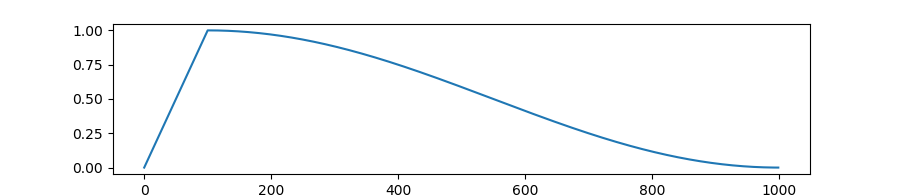

## Training Loop

In [ ]:
# # Read the DataFrame from the CSV file
# df = pd.read_csv('./data/training_outcomes/outcomes_Blip2ForConditionalGeneration_10_03_30_21.csv')

# # Assign each column of the DataFrame to its respective list variable
# epoch_list = df['Epoch'].tolist()
# history_learning_rate = df['Learning_Rate'].tolist()
# loss_values_train = df['Train_Loss'].tolist()
# loss_values_val = df['Validation_Loss'].tolist()
# acc_train = df['Train_Accuracy'].tolist()
# acc_val = df['Validation_Accuracy'].tolist()
# epoch_time = df['Time'].tolist()

# print_messages = ['\n\t ****** Training has begun. ******\n']
# for i in range(0, epoch_list[-1]):
#     message = f'Epoch: {epoch_list[i]:03} | Learning Rate : {history_learning_rate[i]:.6E} | Train Loss: {loss_values_train[i]:.8f} | Val Loss: {loss_values_val[i]:.8f} | Train Acc: {acc_train[i]:.6f} | Val Acc: {acc_val[i]:.6f} | Time: {epoch_time[i]}'
#     print_messages.append(message)

# starting_epoch = epoch_list[-1] + 1
# print(f"Starting epoch : {starting_epoch}")

In [ ]:
# torch.cuda.empty_cache()

# epoch_list = []
# loss_values_train = []
# loss_values_val = []
# acc_train = []
# acc_val = []
# history_learning_rate = []
# epoch_time = []

# print_messages = ['\n\t ****** Training has begun. ******\n']

# starting_epoch = 1
# dt = 0
# # dt = time_to_seconds(epoch_time[-1])

# start = timer()

# update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

# # Training Loop
# for epoch in range(starting_epoch, num_epochs + 1):
#     epoch_list.append(epoch)
    
#     ########################## TRAINING PHASE ###############################
#     model.train()
#     history_learning_rate.append(optimizer.param_groups[0]['lr'])

#     total_loss = 0.0
#     predictions, true_labels = [], []

#     for step, (batch_inputs, batch_true_answer_ids) in enumerate(train_loader, 1):
#         # Move tensors to the GPU
#         batch_inputs = {key: tensor.to(device) for key, tensor in batch_inputs.items()}
#         batch_true_answer_ids = batch_true_answer_ids.to(device)

#         # Forward pass
#         outputs = model(**batch_inputs)
#         logits = outputs.logits

#         # Trim or pad the target tensor to match sequence length
#         if logits.size(1) > batch_true_answer_ids.size(1):
#             # Padding the target tensor
#             padding_size = logits.size(1) - batch_true_answer_ids.size(1)
#             batch_true_answer_ids = F.pad(batch_true_answer_ids, (0, padding_size), value = 0)
#         elif logits.size(1) < batch_true_answer_ids.size(1):
#             # Trimming the target tensor
#             batch_true_answer_ids = batch_true_answer_ids[:, :logits.size(1)]

#         # Reshape logits and target tensor
#         logits_reshaped = logits.reshape(-1, logits.size(-1))
#         targets_reshaped = batch_true_answer_ids.reshape(-1)

#         # Calculate loss
#         loss = loss_function(logits_reshaped, targets_reshaped)

#         # Backward pass with gradient accumulation
#         loss = loss / accumulation_steps
#         loss.backward()
#         total_loss += loss.item()


#         if step % accumulation_steps == 0:
#             optimizer.step()
#             optimizer.zero_grad()

#             # Update the scheduler
#             scheduler.step()

#         # Convert predictions to tokens and calculate F1 Score
#         preds = torch.argmax(logits_reshaped, dim = 1).cpu().detach().numpy()
#         labels = targets_reshaped.cpu().detach().numpy()
#         predictions.extend(preds)
#         true_labels.extend(labels)
    
#         # Release GPU memory after training phase
#         del outputs, logits, batch_inputs, batch_true_answer_ids
#         torch.cuda.empty_cache()

#     avg_train_loss = total_loss / len(train_loader)
#     train_f1 = f1_score(true_labels, predictions, average = 'macro')
#     loss_values_train.append(avg_train_loss)
#     acc_train.append(train_f1)

#     # print(f"Training Loss: {avg_train_loss}, Training F1 Score: {train_f1}")

#     ########################## VALIDATION PHASE ###############################
#     model.eval()
#     total_val_loss = 0.0
#     val_predictions, val_true_labels = [], []
    
#     with torch.no_grad():
#         for batch_inputs, batch_true_answer_ids in val_loader:
#             # Move tensors to the GPU
#             batch_inputs = {key: tensor.to(device) for key, tensor in batch_inputs.items()}
#             batch_true_answer_ids = batch_true_answer_ids.to(device)

#             # Forward pass
#             outputs = model(**batch_inputs)
#             logits = outputs.logits

#             # Trim or pad the target tensor to match sequence length
#             if logits.size(1) > batch_true_answer_ids.size(1):
#                 # Padding the target tensor
#                 padding_size = logits.size(1) - batch_true_answer_ids.size(1)
#                 batch_true_answer_ids = F.pad(batch_true_answer_ids, (0, padding_size), value = 0)
#             elif logits.size(1) < batch_true_answer_ids.size(1):
#                 # Trimming the target tensor
#                 batch_true_answer_ids = batch_true_answer_ids[:, :logits.size(1)]

#             # Reshape logits and target tensor
#             logits_reshaped = logits.reshape(-1, logits.size(-1))
#             targets_reshaped = batch_true_answer_ids.reshape(-1)
            
#             # Calculate loss
#             loss = loss_function(logits_reshaped, targets_reshaped)
#             total_val_loss += loss.item()

#             # Convert predictions to tokens and calculate F1 Score
#             preds = torch.argmax(logits_reshaped, dim = 1).cpu().detach().numpy()
#             labels = targets_reshaped.cpu().detach().numpy()
#             val_predictions.extend(preds)
#             val_true_labels.extend(labels)

#             # Release GPU memory after validation phase
#             del outputs, logits, batch_inputs, batch_true_answer_ids
#             torch.cuda.empty_cache()

#     avg_val_loss = total_val_loss / len(val_loader)
#     val_f1 = f1_score(val_true_labels, val_predictions, average = 'macro')
#     loss_values_val.append(avg_val_loss)
#     acc_val.append(val_f1)


#     # Print training statistics
#     epoch_time.append(timedelta(seconds = int(timer() - start)).__str__().zfill(8))
#     message = f"Epoch: {epoch:03} | Learning Rate : {history_learning_rate[-1]:.6E} | Train Loss: {loss_values_train[-1]:.8f} | Val Loss: {loss_values_val[-1]:.8f} | Train Acc: {acc_train[-1]:.6f} | Val Acc: {acc_val[-1]:.6f} | Time: {epoch_time[-1]}"

#     print_messages.append(message)

#     # Update the plots
#     update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)


# # Wrap up the training process
# end = timer()
# message = '\n\n\t ****** Training has finished. ******\n'
# print_messages.append(message)
# print(message)
# message = f'\tTraining time: {timedelta(seconds = int(end - start) + dt)} [hh:mm:ss]'
# print_messages.append(message)
# print(message)

# # Update the plots
# update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)
    
# # Release GPU memory
# torch.cuda.empty_cache()

#### Save training results and model

In [ ]:
# # Creating the DataFrame
# outcomes = pd.DataFrame(
#     {   'Epoch': epoch_list,
#         'Learning_Rate': history_learning_rate,
#         'Train_Loss': loss_values_train,
#         'Validation_Loss': loss_values_val,
#         'Train_Accuracy': acc_train,
#         'Validation_Accuracy': acc_val,
#         'Time': epoch_time,
#     })

# # saving the DataFrame as a CSV file
# if epoch_list: # Check if epoch_list is not empty
#     outcomes.to_csv(f'./data/training_outcomes/outcomes_{model.__class__.__name__}_{epoch_list[-1]}_{epoch_time[-1].replace(":", "_")}.csv', index = False)
# else:
#     print("epoch_list is empty, so the DataFrame cannot be saved with the specified filename format.")

In [ ]:
# # Saving the Model
# torch.save(model, f'./data/model/model_{model.__class__.__name__}__{epoch_list[-1]}_{epoch_time[-1].replace(":", "_")}.pth')

# # Saving the Model Weights

# torch.save(model.state_dict(), f'./data/model/model_weights_{model.__class__.__name__}__{epoch_list[-1]}_{epoch_time[-1].replace(":", "_")}.pth')

#### Plot of the Loss and the Accuracy History

In [ ]:
# # Create the first plot for loss values
# fig1, ax1 = plt.subplots(figsize = (10, 6))

# ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = 'Train Loss')
# ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = 'Validation Loss')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Loss')
# ax1.legend()
# ax1.set_title('Loss Values')
# ax1.grid(linestyle='--', linewidth = 0.5)

# plt.show()

In [ ]:
# # Create the second plot for accuracy values
# fig2, ax2 = plt.subplots(figsize = (10, 6))

# ax2.plot(range(1, len(acc_train) + 1), acc_train, label = 'Train Accuracy (F1 Score)')
# ax2.plot(range(1, len(acc_val) + 1), acc_val, label = 'Validation Accuracy (F1 Score)')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Accuracy (%)')
# ax2.legend()
# ax2.set_title('Accuracy Values (F1 Score)')
# ax2.grid(linestyle = '--', linewidth = 0.5)

# plt.show()

#### History of the Learning Rate

In [ ]:
# # Plot learning rate values
# plt.figure(figsize = (10, 6))
# plt.plot(range(1, len(history_learning_rate) + 1), history_learning_rate, label = 'Learning Rate')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.legend()
# plt.title('Learning Rate Values')
# plt.grid(linestyle = '--', linewidth = 0.5)

# plt.show()

### Test the Model on a Sample from the Dataset After Training

In [ ]:
# MAX_TOKENS = 512 - 3  # 1 for [CLS], 1 for [SEP], 1 for safety

# results = []

# # Select 20 records from df_final
# df_samples = df_final[1000:1020]

# # Iterate over the df_samples dataframe
# for idx, (index, row) in enumerate(df_samples.iterrows(), start=1):
#     print(f"\rProcessing record: {idx}/{len(df_samples)}", end="")
    

#     # Load image
#     image_path = row['path']
#     image = Image.open(image_path)
    
#     # Construct the prompt
#     question = "Question: " + row['question']
#     transcript = row['transcript']
#     full_prompt = transcript + " " + question + " Answer:"

#     # Truncate the text to fit within the model's token limit
#     inputs = processor(text = full_prompt, return_tensors = "pt", truncation = True, max_length = MAX_TOKENS)
#     truncated_text = processor.decode(inputs['input_ids'][0])
    
    
#     # Process inputs
#     inputs = processor(images = image, text = truncated_text, return_tensors = "pt").to(device, torch.float16)

#     # Generate answer
#     generated_ids = model.generate(**inputs)
#     generated_text = processor.batch_decode(generated_ids, skip_special_tokens = True)[0].strip()

#     # Append results
#     results.append({
#         'question': row['question'],
#         'transcript': row['transcript'],
#         'true_answer': row['answer'],
#         'generated_answer': generated_text
#     })

# # Print a new line to clear the progress line
# print()

# # Convert results to dataframe
# df_results_after_training = pd.DataFrame(results)

In [ ]:
# df_results_after_training

In [ ]:
# def align_tensors(tensor1, tensor2):
#     """
#     Align two tensors along the sequence length dimension.
#     If tensor1 is shorter, it will be padded. If it's longer, it will be truncated.
#     """
#     len1, len2 = tensor1.shape[1], tensor2.shape[1]
    
#     if len1 < len2:
#         # Pad tensor1
#         padding_shape = list(tensor1.shape)
#         padding_shape[1] = len2 - len1
#         padding = torch.zeros(padding_shape, dtype=tensor1.dtype, device=tensor1.device)
#         tensor1 = torch.cat([tensor1, padding], dim=1)
#     elif len1 > len2:
#         # Truncate tensor1
#         tensor1 = tensor1[:, :len2]
        
#     return tensor1, tensor2

In [ ]:
# model.eval()


# # Convert df_final to DataLoader if you wish to use batches. For now, we'll just use one sample.
# sample = df_final.iloc[6]


# # Load image
# image_path = sample['path']
# image = Image.open(image_path)

# # Construct the prompt
# question = "Question: " + sample['question']
# transcript = sample['transcript']
# full_prompt = transcript + " " + question + " Answer:"

# # Truncate the text to fit within the model's token limit
# inputs = processor(text = full_prompt, return_tensors = "pt", truncation = True, max_length = MAX_TOKENS)
# truncated_text = processor.decode(inputs['input_ids'][0])

# # Process inputs
# inputs = processor(images = image, text = truncated_text, return_tensors = "pt").to(device, torch.float16)

# # Tokenize the true answer
# true_answer = sample['answer']
# true_answer_ids = processor(text = true_answer, return_tensors = "pt")['input_ids'][0].to(device)
# # print(f"\ntrue_answer_ids = {true_answer_ids}")


# # Check model parameters for NaNs or Infs
# for name, param in model.named_parameters():
#     if torch.isnan(param).any() or torch.isinf(param).any():
#         print(f"Parameter {name} has NaN/Inf values!")

# # Check inputs for NaNs or Infs
# if torch.isnan(inputs["input_ids"]).any() or torch.isinf(inputs["input_ids"]).any():
#     print("Input IDs contain NaN/Inf values!")



# # Generate answer
# outputs = model(**inputs)
# logits = outputs.logits
# generated_ids = model.generate(**inputs)

# # print(f"\ngenerated_ids = {generated_ids}")

# generated_answer = ''.join(processor.batch_decode(generated_ids, skip_special_tokens = True)).strip()


# print(f"\ntrue_answer_back = {true_answer}")
# print(f"\ngenerated_answer = {generated_answer}")

# # generated_ids, true_answer_ids = pad_tensors_to_same_length(generated_ids, true_answer_ids)


# # print(f"\ntrue_answer_ids = {true_answer_ids}")
# # print(f"\ngenerated_ids = {generated_ids}")

# # Align the logits and true_answer_ids
# logits, true_answer_ids = align_tensors(logits, true_answer_ids.unsqueeze(0))


# # print(f"\nlogits.shape = {logits.shape}")

# # Compute the loss
# loss = loss_function(logits.view(-1, logits.size(-1)), true_answer_ids.view(-1))


# print(f"\nLoss: {loss.item()}, Accuracy as F1 Score:: {get_f1_score(true_answer, generated_answer)}")

In [ ]:
# num_samples = 300

In [ ]:
# from_beginning = True

In [ ]:
# # Release GPU memory cache
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()

# # Training process
# if from_beginning:

#     epoch_list = []
#     loss_values_train = []
#     loss_values_val = []
#     acc_train = []
#     acc_val = []
#     history_learning_rate = []
#     epoch_time = []

#     print_messages = ['\n\t ****** Training has begun. ******\n']

#     starting_epoch = 1
#     # print(f"Starting epoch : {starting_epoch}")

#     start = timer()
#     dt = 0


# else:
#     # Load
#     my_outcomes = pd.read_csv("./data/checkpoints/checkpoint_1.csv")

#     epoch_list = my_outcomes.Epoch.T.tolist()
#     loss_values_train = my_outcomes.Train_Loss.T.tolist()
#     loss_values_val = my_outcomes.Validation_Loss.T.tolist()
#     acc_train = my_outcomes.Train_Accuracy.T.tolist()
#     acc_val = my_outcomes.Validation_Accuracy.T.tolist()
#     history_learning_rate = my_outcomes.Learning_Rate.T.tolist()
#     epoch_time = my_outcomes.Time.T.tolist()

#     print_messages = ['\n\t ****** Training has begun. ******\n']
#     for i in range(0, epoch_list[-1]):
#         message = f'Epoch: {epoch_list[i]:03} | Learning Rate : {history_learning_rate[i]:.5E} | Train Loss: {loss_values_train[i]:.4f} | Val Loss: {loss_values_val[i]:.4f} | Train Acc: {acc_train[i]:.4f} | Val Acc: {acc_val[i]:.4f} | Time: {epoch_time[i]}'
#         print_messages.append(message)

#     starting_epoch = epoch_list[-1] + 1
#     # print(f"Starting epoch : {starting_epoch}")

#     start = timer()
#     dt = time_to_seconds(epoch_time[-1])


# # update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)



# for epoch in range(starting_epoch, num_epochs + 1):

#     if len(epoch_list) == 0:
#         epoch_list.append(1)
#     else:
#         epoch_list.append(epoch_list[-1] + 1)

#      ########################## TRAINING ###############################

#     # Set the model to training mode
#     model.train()
#     history_learning_rate.append(optimizer.param_groups[0]['lr'])

#     train_correct, train_loss, sample_len = 0, 0, 0

#     for idx in range(num_samples):  # Iterate over the first 20 samples
#         # print(f"\rEpoch: {epoch + 1}, Sample: {idx} ", end="")
#         sample = df_final.iloc[idx]

#         # Load image
#         image_path = sample['path']
#         image = Image.open(image_path)

#         # Construct the prompt
#         question = "Question: " + sample['question']
#         transcript = sample['transcript']
#         full_prompt = transcript + " " + question + " Answer:"

#         # Truncate the text to fit within the model's token limit
#         inputs = processor(text = full_prompt, return_tensors = "pt", truncation = True, max_length = MAX_TOKENS)
#         truncated_text = processor.decode(inputs['input_ids'][0])

#         # Process inputs
#         inputs = processor(images = image, text = truncated_text, return_tensors = "pt").to(device, torch.float16)

#         # Tokenize the true answer
#         true_answer = sample['answer']
#         true_answer_ids = processor(text = true_answer, return_tensors = "pt")['input_ids'][0].to(device)

#         # Generate answer (forward pass)
#         outputs = model(**inputs)
#         logits = outputs.logits
#         generated_ids = model.generate(**inputs)
        
#         generated_answer = ''.join(processor.batch_decode(generated_ids, skip_special_tokens = True)).strip()

#         # Align the logits and true_answer_ids
#         logits, true_answer_ids = align_tensors(logits, true_answer_ids.unsqueeze(0))
        
#         # Calculate L2 regularization term
#         # l2_lambda = 1e-6  # Adjust the regularization strength
#         # l2_reg = sum(p.pow(2.0).sum() for p in model.parameters())
        
#         # Compute the loss
#         loss = loss_function(logits.view(-1, logits.size(-1)), true_answer_ids.view(-1)) # +  l2_lambda * l2_reg

#         # Accumulate loss
#         train_loss += loss.item()

#         # Accumulate correct, Calculate F1 score
#         train_correct += get_f1_score(true_answer, generated_answer)

#         # Backward pass and optimization
#         loss.backward()

#         # Gradient accumulation logic
#         if (idx + 1) % accumulation_steps == 0:
            
#              # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 25.0)

#             # Update model parameters
#             optimizer.step()

#             # Zero the gradients
#             optimizer.zero_grad()

#     # Update learning rate
#     scheduler.step()

#     # Store the average loss for visualization
#     loss_values_train.append(train_loss / num_samples)
#     acc_train.append(train_correct / train_loss)

#      # After loss.backward()
#         # for name, param in model.named_parameters():
#         #     if param.grad is not None:
#         #         grad_norm = param.grad.data.norm(2).item()
#         #         print(f"Layer: {name}, Gradient Norm: {grad_norm}")

#     # Print training statistics
#     epoch_time.append(timedelta(seconds = int(timer() - start) + dt))

#     # Print epoch and average loss
#     print(f"Epoch: {epoch:03} | Learning Rate : {history_learning_rate[-1]:.6E} | Train Loss: {loss_values_train[-1]:.8f} | Train Acc: {acc_train[-1]:.4f} | Time: {epoch_time[-1]}")

# print("\nTraining complete!")

In [ ]:
# # Load
# checkpoint = torch.load('./data/checkpoints/checkpoint_1.pth')

# model = checkpoint['model']
# optimizer.load_state_dict(checkpoint['optimizer'])
# lr_scheduler.load_state_dict(checkpoint['scheduler'])

In [ ]:
# from_beginning = True